In [39]:
#Refer to https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6
#Refer to: https://github.com/JanSchm/CapMarket/blob/master/bot_experiments/IBM_Transformer%2BTimeEmbedding.ipynb
#Train and then validate and test the model

In [40]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.9.1


## Hyperparameters

In [41]:
batch_size = 32
seq_len = 43 # seq_len=43 意思是用43天的数据预测第44天后的趋势
column_len = 8 #6. the number of column
predict_column = 7 #5 (result). which column to be predict, from 0 to column_len-1
d_k = 256 #256
d_v = 256 #256
n_heads = 12 #12
ff_dim = 256 #256
epochs = 3 #20
#
stock_id = '300059'
use_checkpoints_id = None #None or else. use other's pre-train model instead of itself(None)
train_from_scratch = True  # True: Train the model, False: Use the pre-train checkpoints
stock_price_path = 'stockData/' + stock_id + '_ind.csv'
preictLen = 86 #Length of test date for predict, -1 means this args is ignore (10% pct is use for test);0 means predict the next date, 1 means predict today and next date... 

In [42]:
#Load data from DB to csv file
from postgres import PostgresDBHandler
postgres = PostgresDBHandler()
length = 1000 # postgres.get_stock_price_indicator_and_save_to_file(stock_id) or get_stock_price_and_save_to_file(stock_id)
#TODO: Should remove the first row of df
if length < 500 and train_from_scratch == 'True':
    print('Length of stock price ' + stock_id + ' is too small (len=' + str(length) + ') for train, pls use other checkpoint for predict')
    sys.exit()

# Moving Average

## Moving Average - Load data again, to apply rolling window

In [43]:
df = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume', 'h1', 'h2'])

# Replace 0 to avoid dividing by 0 later on
df['volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('date', inplace=True)


# Apply moving average with a window of 10 days to all columns
#df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].rolling(10).mean() 

# the max close price in next 19 days
df['Max_Close_Price_In_Next_N_Days'] = df['close'].rolling(20).max().shift(-19)
# the close price after 10 days
df['Close_Price_After_N_Days'] = df['close'].shift(-19)

# Close price is less than the max close price after 19 days
df['Max_Close_Diff'] = df['Max_Close_Price_In_Next_N_Days'] - df['close']
df['Close_Diff'] = df['Close_Price_After_N_Days'] - df['close']

# Result should be a predict number, 1 means the price trend is increase 
# (the max close and close within next 10 days is higher then current price)

df['Result'] = 0
df.loc[(df['Max_Close_Diff'] > 0) & (df['Close_Diff'] > 0), ['Result']] = 1

# Apply moving average with a window of 10 days to all columns
#df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].rolling(10).mean() 

df.to_csv('stockData/' + stock_id + '_result.csv')

del df['Max_Close_Diff']
del df['Close_Diff']
del df['Close_Price_After_N_Days']
del df['Max_Close_Price_In_Next_N_Days']

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head(46)

,date,open,high,low,close,volume,h1,h2,Result
0,2010-03-22,0.74,0.78,0.73,0.78,110104,41.901,56.618,1
1,2010-03-23,0.76,0.79,0.76,0.79,85522,30.158,53.833,1
2,2010-03-24,0.79,0.87,0.78,0.83,72530,21.782,50.459,1
3,2010-03-25,0.83,0.87,0.82,0.84,60225,15.801,46.811,1
4,2010-03-26,0.83,0.84,0.81,0.83,43154,11.527,43.097,1
5,2010-03-29,0.83,0.90,0.81,0.89,67686,8.490,39.454,0
6,2010-03-30,0.88,0.97,0.88,0.96,48331,6.342,35.969,0
7,2010-03-31,0.96,1.05,0.94,1.05,58812,4.833,32.691,0
8,2010-04-01,1.05,1.14,1.03,1.05,61479,3.755,29.645,0
9,2010-04-02,1.03,1.10,1.03,1.07,49702,2.991,26.839,0


## Moving Average - Plot daily closing prices and volume

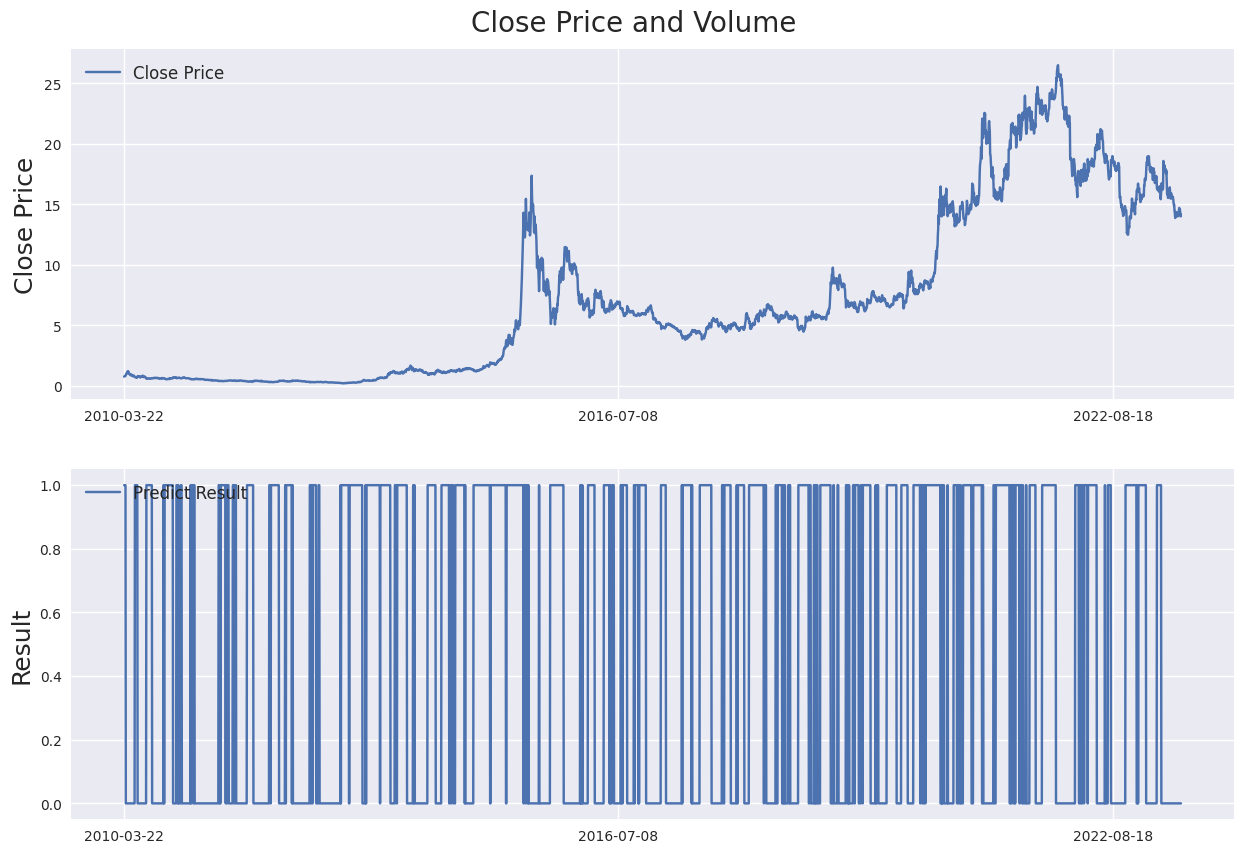

In [44]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['close'], label='Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Result'], label='Predict Result')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['date'].loc[::1464])
ax2.set_ylabel('Result', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)
plt.show()

## Moving Average - Calculate normalized percentage change for all columns

In [45]:
'''Calculate percentage change''' 
df['open'] = df['open'].pct_change() # Create arithmetic returns column
df['high'] = df['high'].pct_change() # Create arithmetic returns column
df['low'] = df['low'].pct_change() # Create arithmetic returns column
df['close'] = df['close'].pct_change() # Create arithmetic returns column
df['volume'] = df['volume'].pct_change()
df['h1'] = df['h1'].pct_change()
df['h2'] = df['h2'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#Why min max is based on index < 20 pct? Why Not based on all?
min_return = min(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['open'] = (df['open'] - min_return) / (max_return - min_return)
df['high'] = (df['high'] - min_return) / (max_return - min_return)
df['low'] = (df['low'] - min_return) / (max_return - min_return)
df['close'] = (df['close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''
#Why min max is based on index < 20 pct? Why Not based on all?
min_volume = df[(df.index < last_20pct)]['volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['volume'] = (df['volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Normalize h1,h2 column'''
#Why min max is based on index < 20 pct? Why Not based on all?
min_h1 = df[(df.index < last_20pct)]['h1'].min(axis=0)
max_h1 = df[(df.index < last_20pct)]['h1'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['h1'] = (df['h1'] - min_h1) / (max_h1 - min_h1)

min_h2 = df[(df.index < last_20pct)]['h2'].min(axis=0)
max_h2 = df[(df.index < last_20pct)]['h2'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['h2'] = (df['h2'] - min_h2) / (max_h2 - min_h2)

###############################################################################
'''Normalize Result column'''

min_result = df[(df.index < last_20pct)]['Result'].min(axis=0)
max_result = df[(df.index < last_20pct)]['Result'].max(axis=0)

# Min-max normalize Result columns (0-1 range)
#It seams if result is either 0 or 1, then it does not need normalize
df['Result'] = (df['Result'] - min_result) / (max_result - min_result)
###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]


if train_from_scratch == False and preictLen != -1:
    #if train_from_scratch is False
    #self.seq_len + self.preictLen + 1: the last +1 is for the prediction date
    df_test = df[-(seq_len + preictLen + 1):]
    df_test_with_date = df[-(seq_len + preictLen + 1):]                                    
else:
    #if train_from_scratch is True, then use the only last 10 pct for predict
    df_test = df[(df.index >= last_10pct)]
    df_test_with_date = df[(df.index >= last_10pct)]        

# Remove date column
df_train.drop(columns=['date'], inplace=True)
df_val.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

#cheat my self?
#df_test['Result']=0

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
test_data_with_date = df_test_with_date.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))
print('df_test_with_date data shape: {}'.format(df_test_with_date.shape))

print(df_train.head(45))
#print(df_test.head())
#print(test_data)
#print(df_test_with_date)

Training data shape: (2504, 8)
Validation data shape: (313, 8)
Test data shape: (313, 8)
df_test_with_date data shape: (313, 9)
        open      high       low     close    volume        h1        h2  \
1   0.565495  0.532372  0.598296  0.532372  0.049765  0.000000  0.279521   
2   0.594514  0.738583  0.563836  0.620532  0.054480  0.006648  0.199817   
3   0.620532  0.502481  0.622046  0.530571  0.053308  0.014969  0.142955   
4   0.502481  0.422084  0.474048  0.474725  0.045786  0.025778  0.101325   
5   0.502481  0.669017  0.502481  0.671024  0.102094  0.044309  0.070652   
6   0.642933  0.683821  0.703969  0.685858  0.045621  0.071931  0.048190   
7   0.714436  0.694770  0.661448  0.721060  0.078854  0.111696  0.031622   
8   0.721060  0.702325  0.725711  0.502481  0.067518  0.150991  0.019557   
9   0.458071  0.420673  0.502481  0.546891  0.051860  0.202692  0.010823   
10  0.615661  0.672045  0.593025  0.742169  0.062944  0.285250  0.005626   
11  0.718362  0.601274  0.698589  0.

## Moving Average - Plot daily changes of close price and volume

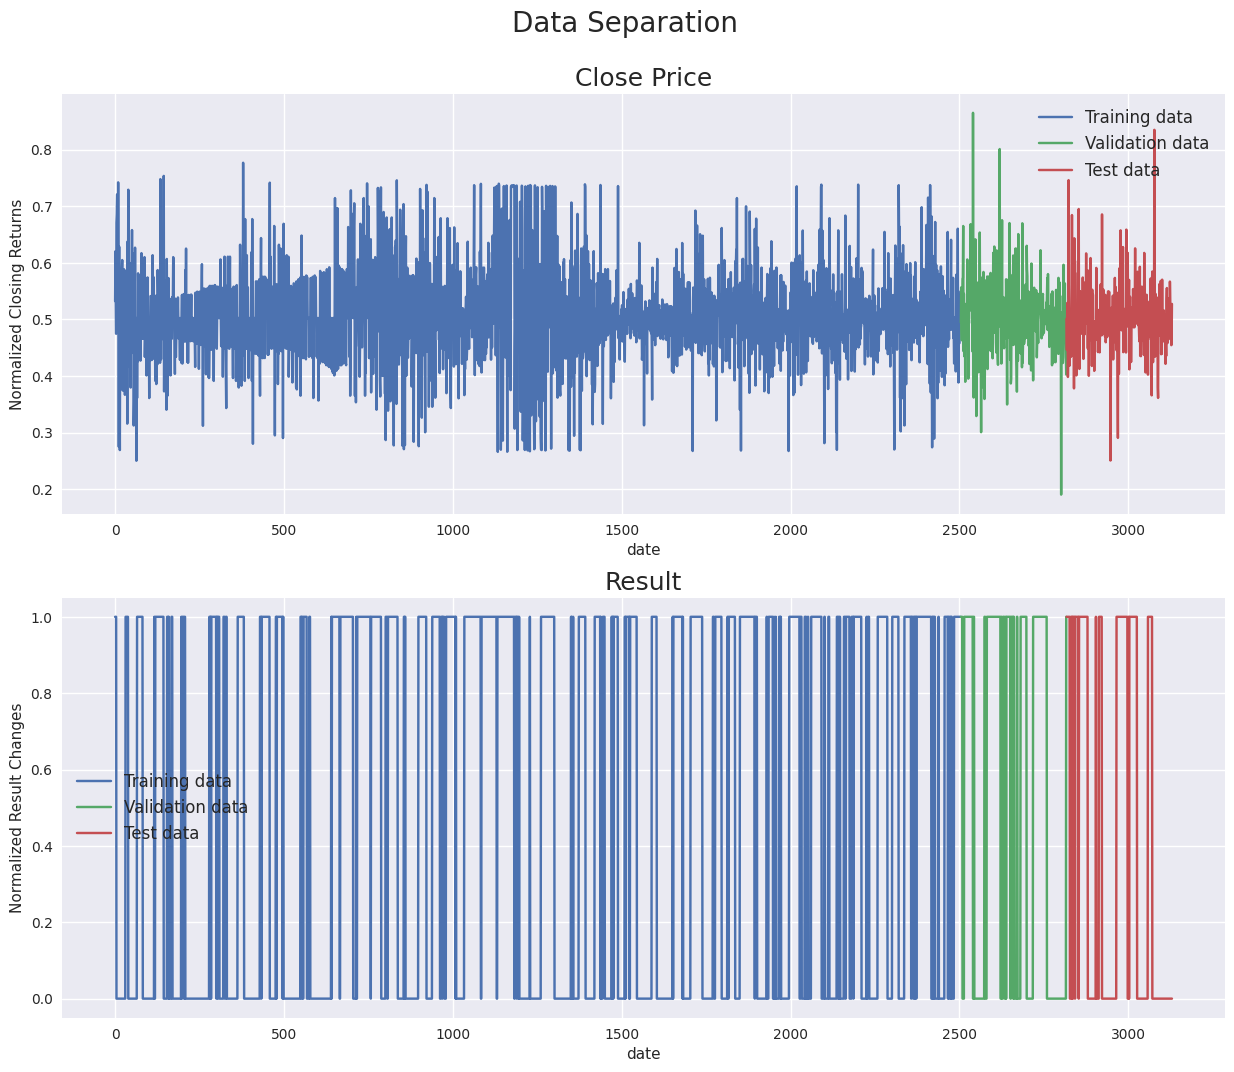

In [46]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['close'], label='Test data')
ax1.set_xlabel('date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Result'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Result'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Result'], label='Test data')
ax2.set_xlabel('date')
ax2.set_ylabel('Normalized Result Changes')
ax2.set_title("Result", fontsize=18)
ax2.legend(loc="best", fontsize=12)
plt.show()

## Moving Average - Create chunks of training, validation, and test data

In [47]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):     ##remove result column for train ,0:5  or 0:7 for include h1&h2
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows; 0~5 column
  y_train.append(train_data[:, predict_column][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])#remove result column for val ,0:5
    y_val.append(val_data[:, predict_column][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
X_test_with_data, X_test_last_43 = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])#remove result column for test ,0:5
    X_test_with_data.append(test_data_with_date[i-seq_len:i])
    y_test.append(test_data[:, predict_column][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

X_test_with_data = np.array(X_test_with_data)
X_test_last_43 = X_test[-1:]
X_test_with_date_last_43 = X_test_with_data[-1:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

print(X_train[1])
print(y_train[1])

(2461, 43, 8) (2461,)
(270, 43, 8) (270,)
(270, 43, 8) (270,)
[[5.94514206e-01 7.38583271e-01 5.63836426e-01 6.20532069e-01
  5.44801583e-02 6.64764402e-03 1.99816729e-01 1.00000000e+00]
 [6.20532069e-01 5.02480868e-01 6.22045546e-01 5.30571365e-01
  5.33076626e-02 1.49690575e-02 1.42955461e-01 1.00000000e+00]
 [5.02480868e-01 4.22083929e-01 4.74047804e-01 4.74724782e-01
  4.57861755e-02 2.57783414e-02 1.01324577e-01 1.00000000e+00]
 [5.02480868e-01 6.69017384e-01 5.02480868e-01 6.71023848e-01
  1.02093632e-01 4.43093340e-02 7.06515559e-02 0.00000000e+00]
 [6.42933351e-01 6.83820630e-01 7.03969492e-01 6.85858155e-01
  4.56210021e-02 7.19305610e-02 4.81903511e-02 0.00000000e+00]
 [7.14436434e-01 6.94770454e-01 6.61447542e-01 7.21060045e-01
  7.88538472e-02 1.11696147e-01 3.16224211e-02 0.00000000e+00]
 [7.21060045e-01 7.02324687e-01 7.25710666e-01 5.02480868e-01
  6.75180018e-02 1.50991174e-01 1.95571605e-02 0.00000000e+00]
 [4.58071130e-01 4.20673456e-01 5.02480868e-01 5.46890606e-01
 

## Moving Average - Model

In [48]:
from model.transformer import TransformerEncoder
from model.transformer import Time2Vector
from model.transformer import MultiAttention
from model.transformer import SingleAttention
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, column_len)) #remove result column for train: column_len - 1
  x = time_embedding(in_seq)    
    
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  #out = Dense(1, activation='linear')(x)
  out = Dense(1, activation='sigmoid')(x) #predict 1 or 0

  model = Model(inputs=in_seq, outputs=out)
  #model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])#linear use mse
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'mape'])#sigmoid use binary_crossentropy
  return model


model = create_model()
model.summary()

ckp = './checkpoints/Transformer+TimeEmbedding_' + str(seq_len) + '_' + stock_id + '.hdf5'
callback = tf.keras.callbacks.ModelCheckpoint(ckp, 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

if train_from_scratch:
    history = model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=[callback],
                        validation_data=(X_val, y_val))  
else:
    if use_checkpoints_id != None:
        ckp = './checkpoints/Transformer+TimeEmbedding_' + str(seq_len) + '_' + use_checkpoints_id + '.hdf5'
        
    model = tf.keras.models.load_model(ckp,
                                       custom_objects={'Time2Vector': Time2Vector, 
                                                       'SingleAttention': SingleAttention,
                                                       'MultiAttention': MultiAttention,
                                                       'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 43, 8)]      0           []                               
                                                                                                  
 time2_vector_5 (Time2Vector)   (None, 43, 2)        172         ['input_2[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 43, 10)       0           ['input_2[0][0]',                
                                                                  'time2_vector_5[0][0]']         
                                                                                                  
 transformer_encoder_15 (Transf  (None, 43, 10)      137532      ['concatenate_1[0][0]',    

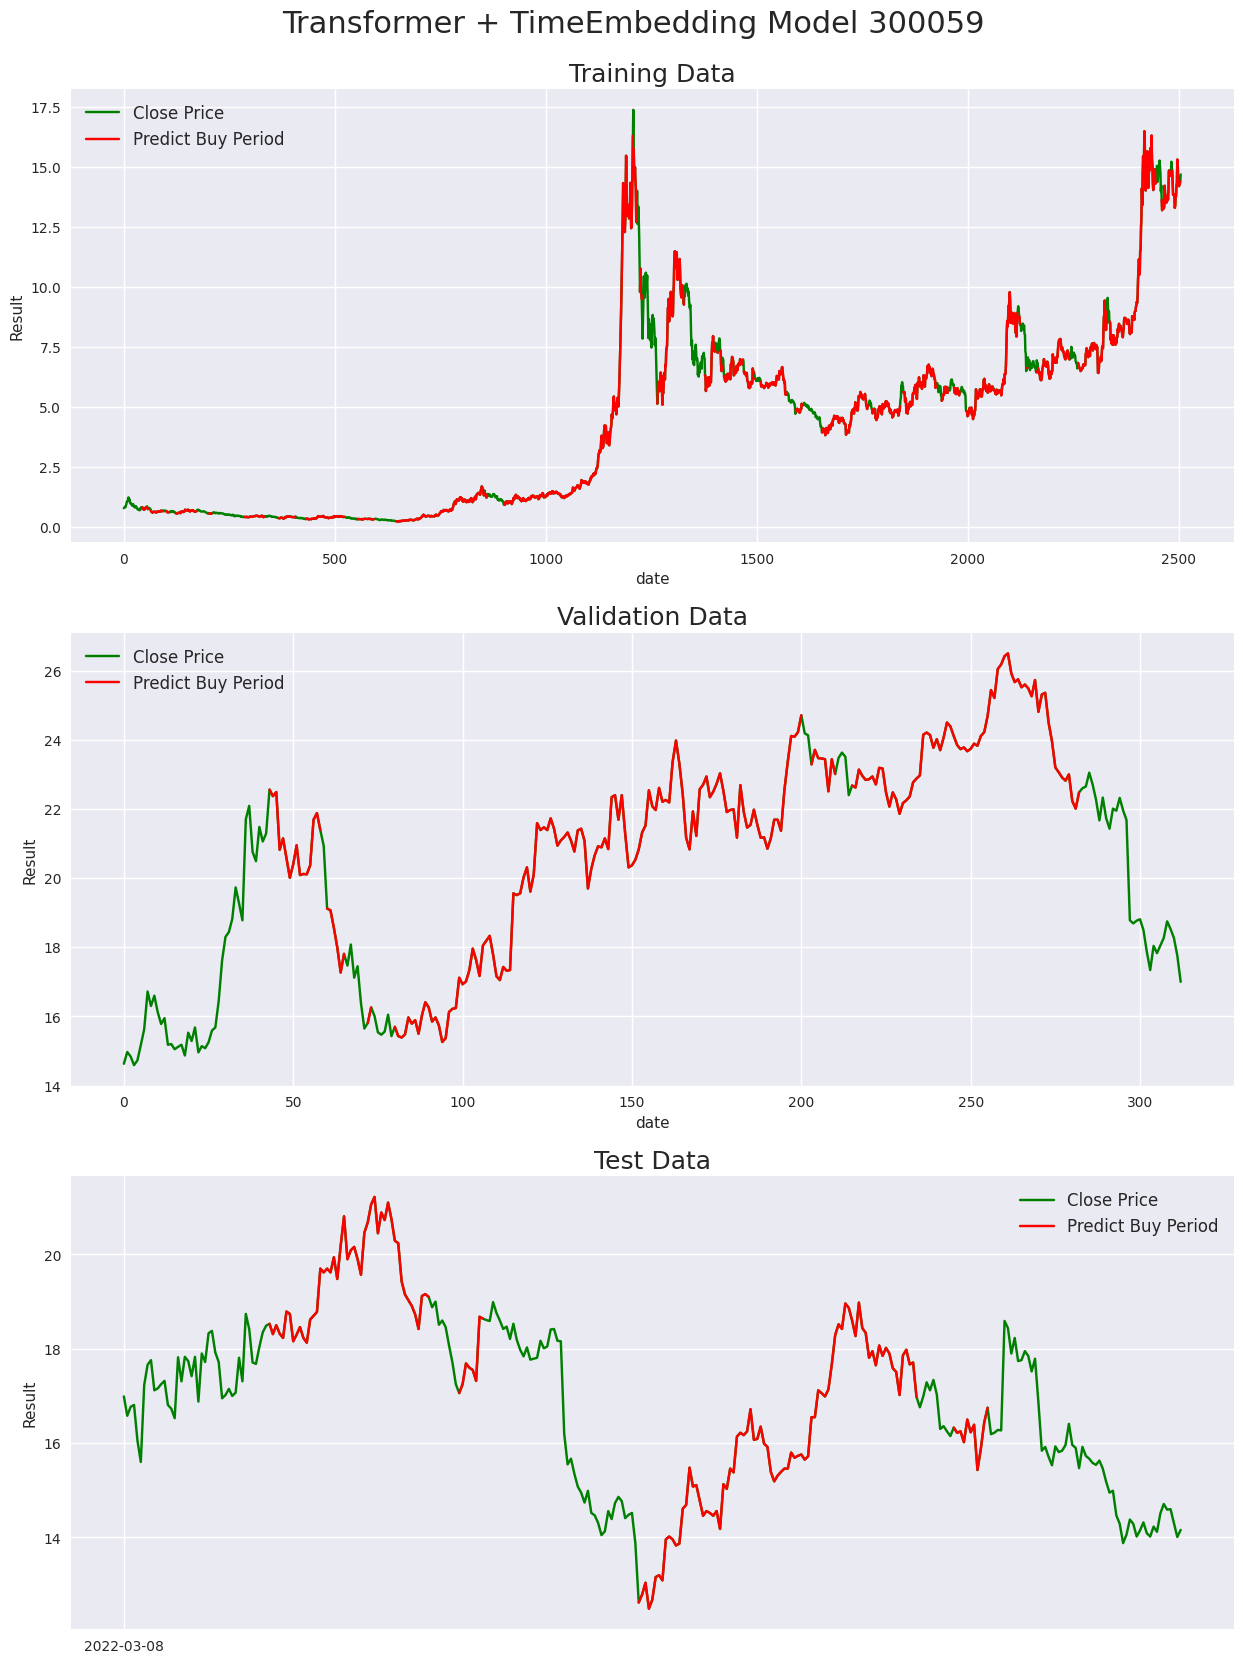

In [49]:
###############################################################################
'''Display results'''

df2 = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
df2.sort_values('date', inplace=True)
df2_close = df2['close'].values

df2_test_close_price   = df2_close[-len(test_data):]
df2_val_close_price    = df2[(df2.index >= last_20pct) & (df2.index < last_10pct)]['close'].values
df2_train_close_price  = df2[(df2.index < last_20pct)]['close'].values
####

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model " + stock_id, fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
#ax11.plot(train_data[:, 3], label='Result')
ax11.plot(df2_train_close_price, label='Close Price', color='g')
#ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Result')

df2_train_close_price_4_show = df2_train_close_price[-(len(df2_train_close_price)-seq_len):]
states_buy = []
index = 0
for pred in train_pred:
    if pred >= 0.75:
        states_buy.append(df2_train_close_price_4_show[index])
    else:
        states_buy.append(None)
    index += 1    
        
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), states_buy, label='Predict Buy Period', color='r')

ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('date')
ax11.set_ylabel('Result')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
#ax21.plot(val_data[:, 3], label='Result')
ax21.plot(df2_val_close_price, label='Close Price', color='g')
#ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Result')

df2_val_close_price_4_show = df2_val_close_price[-(len(df2_val_close_price)-seq_len):]
states_buy = []
index = 0
for pred in val_pred:
    if pred >= 0.75:
        states_buy.append(df2_val_close_price_4_show[index])
    else:
        states_buy.append(None)
    index += 1    
        
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), states_buy, label='Predict Buy Period', color='r')


ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('date')
ax21.set_ylabel('Result')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
#ax31.plot(test_data[:, 3], label='Result')
ax31.plot(df2_test_close_price, label='Close Price', color='g')
#ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Result')

df2_test_close_price_4_show = df2_test_close_price[-(len(df2_test_close_price)-seq_len):]
states_buy = []
index = 0
for pred in test_pred:
    if pred >= 0.75:
        states_buy.append(df2_test_close_price_4_show[index])
    else:
        states_buy.append(None)
    index += 1    
            
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), states_buy, label='Predict Buy Period', color='r')

#
ax31.set_title("Test Data", fontsize=18)
#ax31.set_xlabel('date')
ax31.set_xticks(range(0, df_test_with_date.shape[0], 1464))
ax31.set_xticklabels(df_test_with_date['date'].loc[::1464])
ax31.set_ylabel('Result')
ax31.legend(loc="best", fontsize=12)
plt.show()

## Moving Average - Model metrics

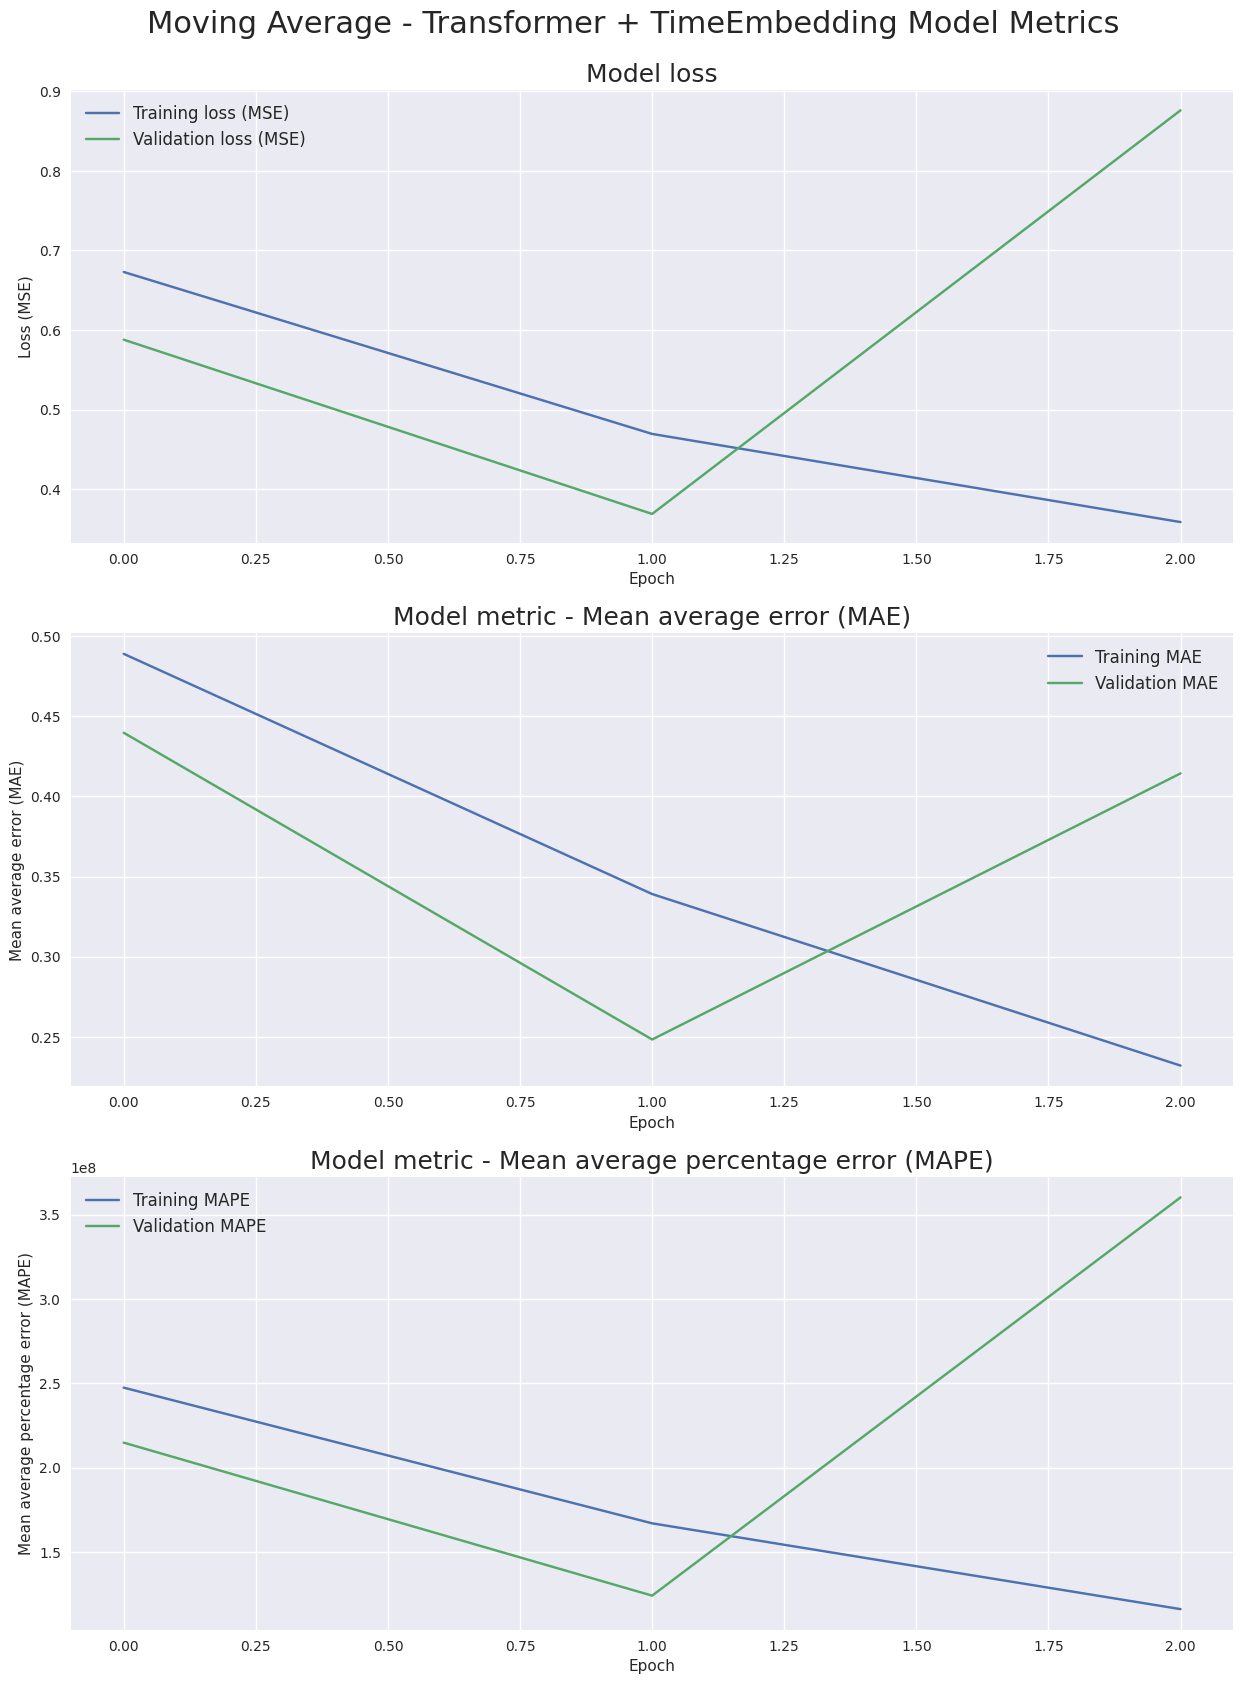

In [50]:
'''Display model metrics'''
if train_from_scratch:
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
    st.set_y(0.92)

    #Plot model loss
    ax1 = fig.add_subplot(311)
    ax1.plot(history.history['loss'], label='Training loss (MSE)')
    ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
    ax1.set_title("Model loss", fontsize=18)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend(loc="best", fontsize=12)

    #Plot MAE
    ax2 = fig.add_subplot(312)
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean average error (MAE)')
    ax2.legend(loc="best", fontsize=12)

    #Plot MAPE
    ax3 = fig.add_subplot(313)
    ax3.plot(history.history['mape'], label='Training MAPE')
    ax3.plot(history.history['val_mape'], label='Validation MAPE')
    ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Mean average percentage error (MAPE)')
    ax3.legend(loc="best", fontsize=12)
    plt.show()

In [51]:
print(X_test.shape, y_test.shape)
#test_pred = model.predict(X_test)

print('len of test_pred:', len(test_pred))
df_test_with_date=df_test_with_date[-(len(df_test_with_date)-seq_len):]
print('len of df_test_with_date:', len(df_test_with_date))

#print('last 60 of test_pred:',test_pred[-60:])
#print('last 60 of df_test_with_date:',df_test_with_date['date'][-60:])

#for pred in test_pred:
#    print(pred)
#for date in df_test_with_date['date'].values:
#    print(date)

(270, 43, 8) (270,)
len of test_pred: 270
len of df_test_with_date: 270


In [52]:
#Save AI predict to DB
import psycopg2
import numpy

#Establishing the connection
conn = psycopg2.connect(
   database="easystogu", user='postgres', password='postgres', host='192.168.10.200', port= '5432'
)
#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#First delete then insert
index=0
for date in df_test_with_date['date'].values:
    result=test_pred[index][0]
    print(stock_id, date, result)
    #cursor.execute("delete from AI_TREND_PREDICTION where stockid=%s and date=%s", (stock_id,date))
    #cursor.execute("insert into AI_TREND_PREDICTION (stockid,date,result) values(%s, %s, %s)", (stock_id, date, result))
    index+=1

# Commit your changes in the database
conn.commit()

# Closing the connection
conn.close()

300059 2022-05-13 0.9145246
300059 2022-05-16 0.9145401
300059 2022-05-17 0.9158549
300059 2022-05-18 0.91543174
300059 2022-05-19 0.9153305
300059 2022-05-20 0.9155633
300059 2022-05-23 0.9144297
300059 2022-05-24 0.91463375
300059 2022-05-25 0.91435874
300059 2022-05-26 0.9150278
300059 2022-05-27 0.91677934
300059 2022-05-30 0.91596097
300059 2022-05-31 0.9162236
300059 2022-06-01 0.9161964
300059 2022-06-02 0.91570365
300059 2022-06-06 0.91524357
300059 2022-06-07 0.91516715
300059 2022-06-08 0.9150297
300059 2022-06-09 0.9152947
300059 2022-06-10 0.91539717
300059 2022-06-13 0.91523916
300059 2022-06-14 0.9133222
300059 2022-06-15 0.91167927
300059 2022-06-16 0.9076549
300059 2022-06-17 0.90648085
300059 2022-06-20 0.90465695
300059 2022-06-21 0.9031516
300059 2022-06-22 0.9019645
300059 2022-06-23 0.901029
300059 2022-06-24 0.89903927
300059 2022-06-27 0.89594406
300059 2022-06-28 0.8938621
300059 2022-06-29 0.89119667
300059 2022-06-30 0.888294
300059 2022-07-01 0.884983
300059 